# Debugging autoreload

In [ ]:
%load_ext autoreload
%autoreload 2

# Load packages

In [18]:
import shap
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import pickle
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from src.models.tabular.widedeep.ft_transformer import WDFTTransformerModel

# Load model and SHAP train data

In [5]:
root_dir = Path(os.getcwd()).parent

fn_model = f"{root_dir}/data/immuno/model.ckpt"
fn_shap = f"{root_dir}/data/immuno/shap.pickle"

model = WDFTTransformerModel.load_from_checkpoint(checkpoint_path=fn_model)
model.eval()
model.freeze()

feats = [
    'CXCL9',
    'CCL22',
    'IL6',
    'PDGFB',
    'CD40LG',
    'IL27',
    'VEGFA',
    'CSF1',
    'PDGFA',
    'CXCL10'
]

def predict_func(x):
    batch = {
        'all': torch.from_numpy(np.float32(x)),
        'continuous': torch.from_numpy(np.float32(x)),
        'categorical': torch.from_numpy(np.int32(x[:, []])),
    }
    return model(batch).cpu().detach().numpy()

with open(fn_shap, 'rb') as handle:
    shap_dict = pickle.load(handle)
values_train = shap_dict['values_train']
shap_values_train = shap_dict['shap_values_train']
explainer = shap_dict['explainer']

# Load target data

In [6]:
# Here we need to obtain new submitted dataframe from the web platform.
# This dataframe must contain the immunomarkers and chronological age.
df = pd.read_excel(f"{root_dir}/data/immuno/data.xlsx", index_col=0)
df = df.loc[:, feats + ['Age']]

# Model inference

In [7]:
df['SImAge'] = model(torch.from_numpy(df.loc[:, feats].values)).cpu().detach().numpy().ravel()
df['SImAge acceleration'] = df['SImAge'] - df['Age']
df['|SImAge acceleration|'] = df['SImAge acceleration'].abs()

# Model metrics

In [15]:
mae = mean_absolute_error(df['Age'].values, df['SImAge'].values)
rho = pearsonr(df['Age'].values, df['SImAge'].values).statistic

# Model plots

## Scatter

C:\Users\user\anaconda3\envs\py39\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\user\anaconda3\envs\py39\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


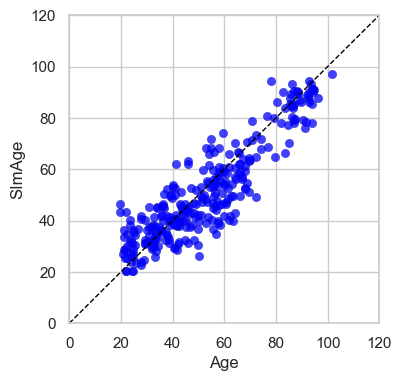

In [26]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(4, 4))
scatter = sns.scatterplot(
    data=df,
    x="Age",
    y="SImAge",
    linewidth=0.1,
    alpha=0.75,
    edgecolor="k",
    s=40,
    color='blue',
    ax=ax
)
bisect = sns.lineplot(
    x=[0, 120],
    y=[0, 120],
    linestyle='--',
    color='black',
    linewidth=1.0,
    ax=ax
)
ax.set_xlim(0, 120)
ax.set_ylim(0, 120)
plt.show()

## Violin

C:\Users\user\anaconda3\envs\py39\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\user\anaconda3\envs\py39\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


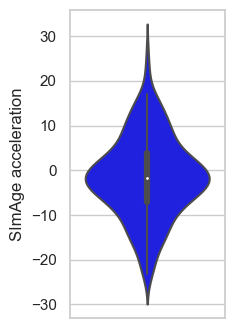

In [27]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(2, 4))
sns.violinplot(
    data=df,
    y='SImAge acceleration',
    scale='width',
    color='blue',
    saturation=0.75,
)
plt.show()

# Global explainability plots

## Bar plot

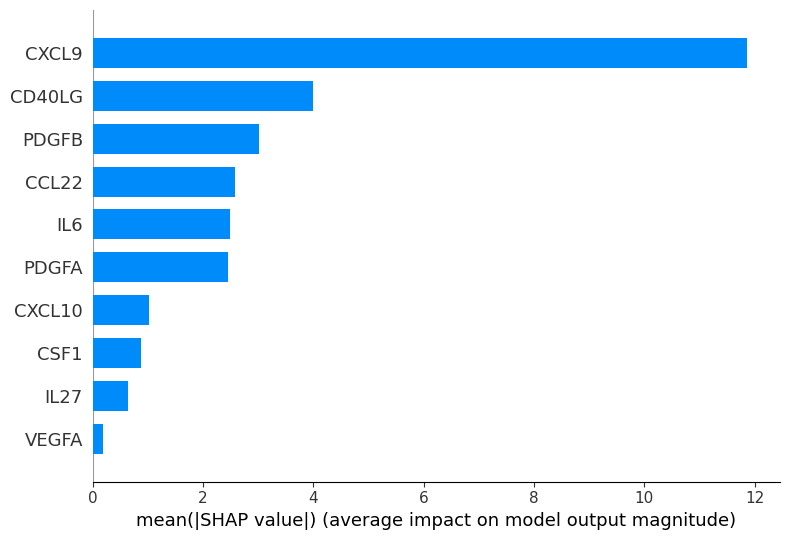

In [8]:
shap.summary_plot(
    shap_values=shap_values_train.values,
    features=values_train.values,
    feature_names=feats,
    max_display=len(feats),
    plot_type="bar",
    show=True,
)

## Violin (beeswarm) plot

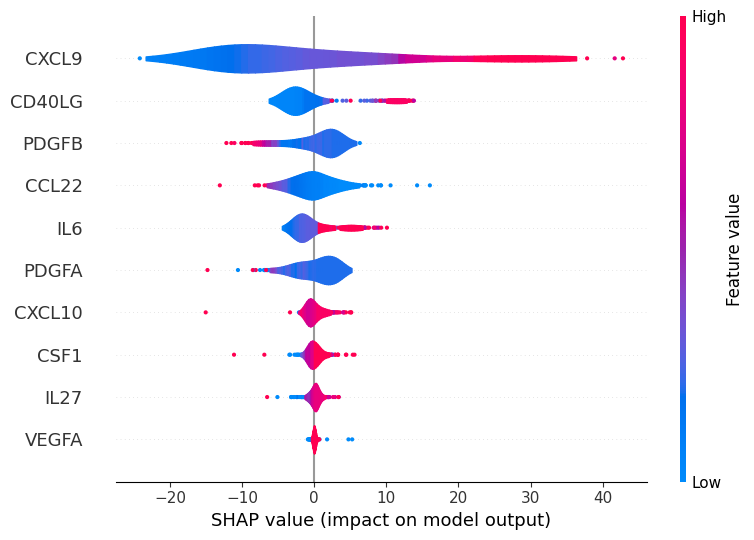

In [9]:
shap.summary_plot(
    shap_values=shap_values_train.values,
    features=values_train.values,
    feature_names=feats,
    max_display=len(feats),
    plot_type="violin",
    show=True,
)

# Local explainability plots

In [10]:
# User need to select target row (or sample ID) in submitted data to obtain local explanation for it.
trgt_id = "trn_val_000"
shap_values_trgt = explainer.shap_values(df.loc[trgt_id, feats].values)
base_value = explainer.expected_value[0]

## Waterfall plot

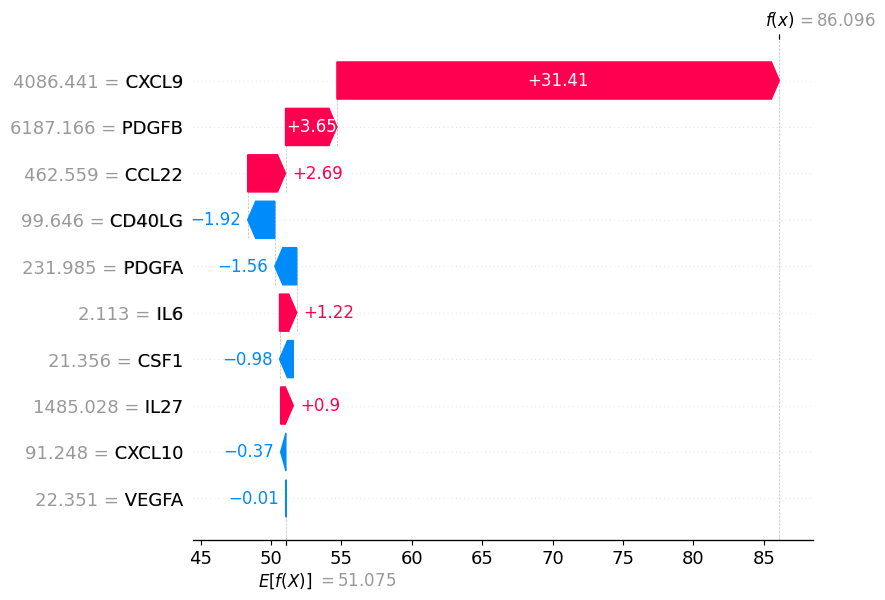

In [13]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values_trgt,
        base_values=base_value,
        data=df.loc[trgt_id, feats].values,
        feature_names=feats
    ),
    max_display=len(feats),
    show=True,
)